# This notebook illustrates 3D gravity inversion on a synthetic density model
Note: the notebook code is not production ready but simplified version only

Workflow:

* generate synthetic density model
    (by defined set of 3D density points),

* calculates gravity field on the surface from the density model,

* use Radon Transform (also known as Focal Average) to produce the inversion model
    (we use fast simplified transform good enough for our demonstration),

*  compare original model isosurfaces and the inversion ones
    (should be orthogonal by the theory),

* compare original model and the inversion model density-depth profiles
    (should be the same for accurate transform, see notes below).

In [1]:
# calculation modules
import xarray as xr
import numpy as np
import pandas as pd
import math
from scipy.ndimage.filters import gaussian_filter

In [2]:
# plotting modules
import matplotlib.pyplot as plt
%matplotlib inline

## Constants and functions

In [3]:
G=6.67408*1e-11
# [m**3]
def volume_sphere(r):
    return 4./3*math.pi*r**3
# delta_density [g/cm**3] -> mass [kg]
def delta_mass_sphere(r, delta_density):
    return 1000.*delta_density*volume_sphere(r)
# [мГал]
def delta_grav(delta_mass, x,y,z):
    return (100.*1000)*G*delta_mass*z/np.power(x**2 + y**2 + z**2, 1.5)

def gaussian(x, y, z, std, amplitude):
    r2 = x**2 + y**2 + z**2
    return amplitude*np.exp(-r2/std**2)

def raster_gamma_range(raster0, g1, g2):
    raster = raster0.copy()
    raster.values = raster.values.astype(np.float32)
    raster.values = gaussian_filter(raster.values,g1,mode='constant', cval=0) \
            - gaussian_filter(raster.values,g2,mode='constant', cval=0)
    return raster

## Synthetic Density Model

In [4]:
# define processing grid
L = 200
Z = 100
x = np.linspace(-L,L,2*L+1)
y = np.linspace(-L,L,2*L+1)
z = -np.arange(1,Z+1)
(xx,yy,zz) = np.meshgrid(x,y,z)

In [5]:
# define sources
X0 = np.array([350,375,400,450,500,550,600,625,650])/2
Y0 = np.array(len(X0)*[0])
Z0 = np.array([50,0,50,25,0+50,25,50,0,50])/2
V0 = [-1,-1,1,-1,-1+0,-1,1,-1,-1]

In [6]:
# save the density sources
pd.DataFrame(list(zip(X0-250, Y0, -Z0, V0)),columns =['X', 'Y', 'Z', 'VALUE'])\
    .to_csv('3D Synthetic Density Inversion by Circular Hough Transform [Focal Average].csv', index=False)

In [7]:
# produce synthetic density
da_density = xr.DataArray(np.zeros(zz.shape),
                          coords={'x': x.astype('float32'), 'y': y.astype('float32'), 'z': z.astype('float32')},
                          dims=['x','y','z']).rename('density')
# add some additive noise if needed
#da_density.values = np.random.rand(da_density.shape[0],da_density.shape[1],da_density.shape[2])-0.5
for (x0,y0,z0,v0) in zip(X0,Y0,Z0,V0):
    da_density.values += gaussian(xx+x0-250, yy+y0, zz+z0, 20, v0)
da_density.values = da_density.transpose('y','x','z').astype('float32').values
da_density['x'] = -da_density.x

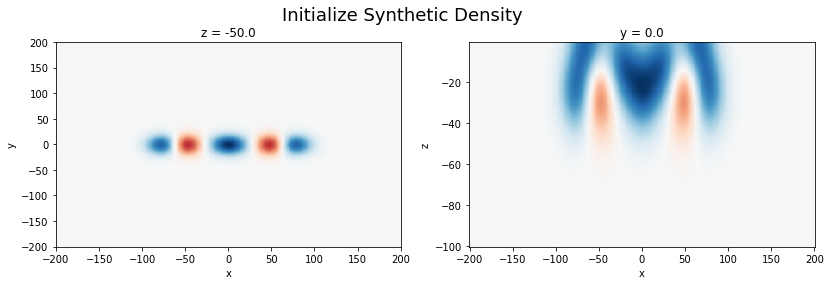

In [8]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1, 2, 1)
da_density.sel(z=-50,method='nearest').T.plot(ax=ax, add_colorbar=False)

ax = fig.add_subplot(1, 2, 2)
da_density.sel(y=0).T.plot(ax=ax, add_colorbar=False)

plt.suptitle('Initialize Synthetic Density', fontsize=18)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.95])
plt.show()

In [9]:
# gaussian filtering is required, see the theory
da_fdensity = raster_gamma_range(da_density, 10,11)

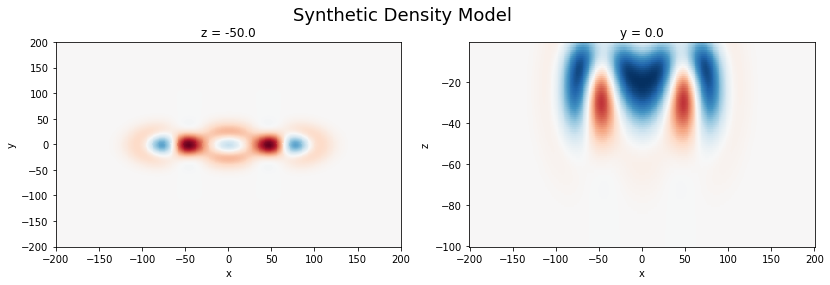

In [10]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1, 2, 1)
da_fdensity.sel(z=-50,method='nearest').T.plot(ax=ax, add_colorbar=False)

ax = fig.add_subplot(1, 2, 2)
da_fdensity.sel(y=0).T.plot(ax=ax, add_colorbar=False)

plt.suptitle('Synthetic Density Model', fontsize=18)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.95])
plt.show()

In [11]:
# save the synthetic density model
da_fdensity.transpose('z','y','x').sel(z=slice(0,-50))\
    .to_netcdf('3D Synthetic Density Inversion by Circular Hough Transform [Focal Average].density.nc')

## Gravity Forward Model

In [12]:
# forward gravity calculation on the surface
def _delta_grav(val, dx, dy, dz):
    return delta_grav(delta_mass_sphere(.5,val), dx, dy, -dz)
da_gravity = xr.apply_ufunc(_delta_grav, da_fdensity, x+da_fdensity.x, y-da_fdensity.y, da_fdensity.z)\
    .sel(z=0, method='nearest')\
    .astype('float32')\
    .rename('gravity')

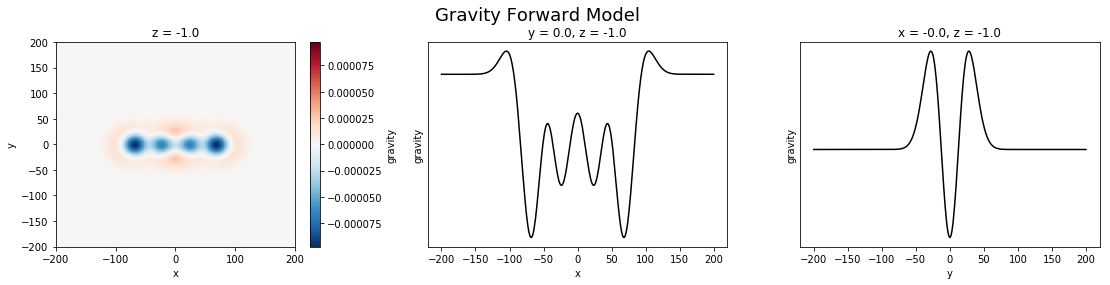

In [13]:
fig = plt.figure(figsize=(16,4))

ax = fig.add_subplot(1, 3, 1)
da_gravity.T.plot(ax=ax)

ax = fig.add_subplot(1, 3, 2)
da_gravity.sel(y=0).plot(ax=ax, c='black')
plt.gca().get_yaxis().set_ticks([])

ax = fig.add_subplot(1, 3, 3)
da_gravity.sel(x=0).plot(ax=ax, c='black')
plt.gca().get_yaxis().set_ticks([])

plt.suptitle('Gravity Forward Model', fontsize=18)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.95])
plt.show()

In [14]:
# save the gravity model
da_gravity.transpose('y','x')\
    .to_netcdf('3D Synthetic Density Inversion by Circular Hough Transform [Focal Average].gravity.nc')

## Circular Hough Transform [Focal Average]
Note: simplified transform is easy but produces some issues (including misrepresented density-depth profile)

In [15]:
# define circular mask
def unit_circle_2d(r):
    A = np.arange(-r,r+1)**2
    dists = np.sqrt( A[:,None] + A)
    if r <= 2:
        return ((dists-r)<=0).astype(int)
    return ((dists-r)<=0.5).astype(int)

In [16]:
# define actual depth 50m
depth = 50
rmax = round(depth*np.sqrt(2))
# transform radius, pixel
rmax

71

In [17]:
# Radon Transformation (Focal Average)
from scipy.signal import convolve2d
rs = np.arange(rmax)
means = []
for r in rs:
    print (r, end=' ')
    mask = unit_circle_2d(r)
    mask[1:-1,1:-1] -= unit_circle_2d(r-1)
    mean = convolve2d(da_gravity, mask/np.sum(mask), mode='same')
    means.append(mean)
means = np.array(means)
# make dataarray
dx = da_gravity.x.diff('x').values[0]
da_focal = xr.DataArray(means, coords=[dx*rs/np.sqrt(2),x,y], dims=['z','x','y']).rename('inversion')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 

In [18]:
# save the inversion model
da_focal.transpose('z','y','x').astype('float32').to_netcdf(
    '3D Synthetic Density Inversion by Circular Hough Transform [Focal Average].inversion.nc',
    encoding= {'inversion': {'zlib': True, 'complevel':9}}
)

## Compare the original and inversion models

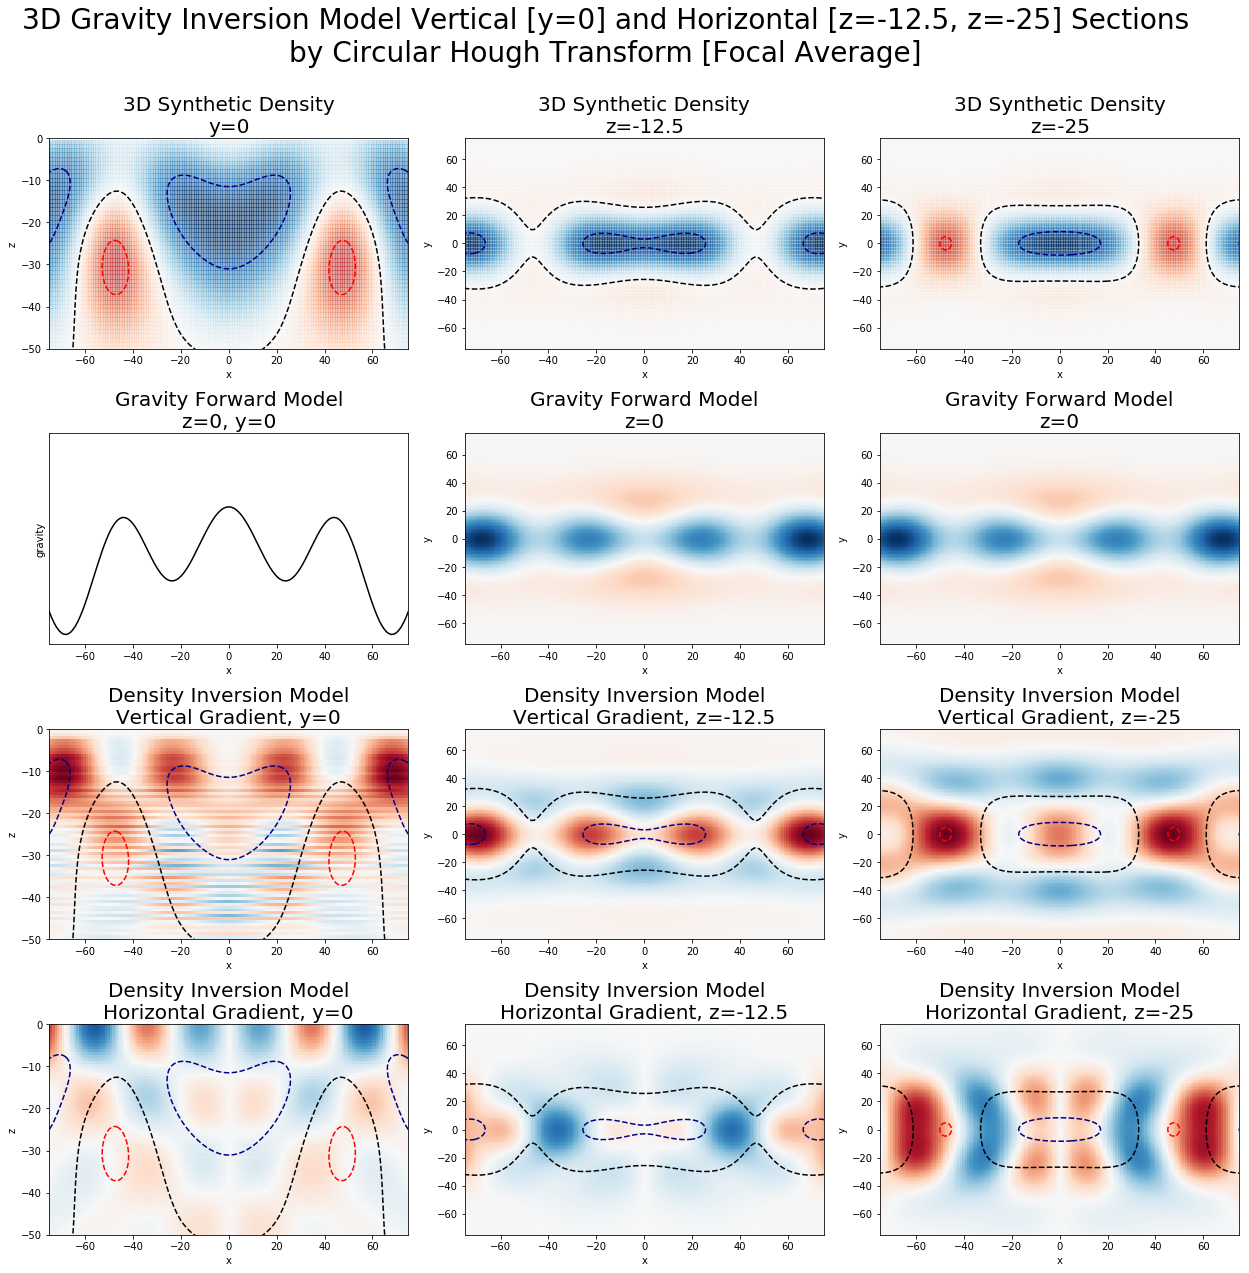

In [19]:
xsize = 75
zsize = 50
levels=[-5e-2,0,4e-2]
colors=['navy','black','red']

fig = plt.figure(figsize=(18,18))

ax = fig.add_subplot(4, 3, 1)
da_fdensity.sel(y=0).T.plot(ax=ax, alpha=0.5, add_colorbar=False)
da_fdensity.sel(y=0).T.plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('3D Synthetic Density\ny=0', fontsize=20)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-zsize, 0])

ax = fig.add_subplot(4, 3, 4)
da_gravity.sel(y=0).plot(ax=ax, c='black')
ax.set_title('Gravity Forward Model\nz=0, y=0', fontsize=20)
ax.get_yaxis().set_ticks([])
ax.set_xlim([-xsize, xsize])

ax = fig.add_subplot(4, 3, 7)
# vertical gradient
grd = da_focal.sel(y=0).diff('z')
grd.plot(ax=ax, add_colorbar=False)
da_fdensity.T.sel(y=0).plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('Density Inversion Model\nVertical Gradient, y=0', fontsize=20)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-zsize, 0])

ax = fig.add_subplot(4, 3, 10)
# radial gradient (from x gradient)
grd = da_focal.sel(y=0).diff('x')
grd.values[:,:200] = -grd.values[:,:200]
grd.plot(ax=ax, add_colorbar=False)
da_fdensity.sel(y=0).T.plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('Density Inversion Model\nHorizontal Gradient, y=0', fontsize=20)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-zsize, 0])

ax = fig.add_subplot(4, 3, 2)
da_fdensity.T.sel(z=-12.5,method='nearest').plot(ax=ax, alpha=0.5, add_colorbar=False)
da_fdensity.T.sel(z=-12.5,method='nearest').plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('3D Synthetic Density\nz=-12.5', fontsize=20)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-xsize, xsize])

ax = fig.add_subplot(4, 3, 5)
da_gravity.T.plot(ax=ax, add_colorbar=False)
ax.set_title('Gravity Forward Model\nz=0', fontsize=20)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-xsize, xsize])

ax = fig.add_subplot(4, 3, 8)
# vertical gradient
grd = da_focal.diff('z')
grd.sel(z=-12.5,method='nearest').T.plot(ax=ax, add_colorbar=False)
da_fdensity.sel(z=-12.5,method='nearest').T.plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('Density Inversion Model\nVertical Gradient, z=-12.5', fontsize=20)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-xsize, xsize])

ax = fig.add_subplot(4, 3, 11)
# radial gradient (from x gradient)
grd = da_focal.sel(z=-12.5, method='nearest').diff('x').T
grd.values[:,:200] = -grd.values[:,:200]
grd.plot(ax=ax, add_colorbar=False)
da_fdensity.sel(z=-12.5,method='nearest').T.plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('Density Inversion Model\nHorizontal Gradient, z=-12.5', fontsize=20)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-xsize, xsize])

ax = fig.add_subplot(4, 3, 3)
da_fdensity.T.sel(z=-25).plot(ax=ax, alpha=0.5, add_colorbar=False)
da_fdensity.T.sel(z=-25).plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('3D Synthetic Density\nz=-25', fontsize=20)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-xsize, xsize])

ax = fig.add_subplot(4, 3, 6)
da_gravity.T.plot(ax=ax, add_colorbar=False)
ax.set_title('Gravity Forward Model\nz=0', fontsize=20)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-xsize, xsize])

ax = fig.add_subplot(4, 3, 9)
# vertical gradient
grd = da_focal.diff('z')
grd.sel(z=-25,method='nearest').T.plot(ax=ax, add_colorbar=False)
da_fdensity.sel(z=-25).T.plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('Density Inversion Model\nVertical Gradient, z=-25', fontsize=20)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-xsize, xsize])

ax = fig.add_subplot(4, 3, 12)
# radial gradient (from x gradient)
grd = da_focal.sel(z=-25, method='nearest').diff('x').T
grd.values[:,:200] = -grd.values[:,:200]
grd.plot(ax=ax, add_colorbar=False)
da_fdensity.sel(z=-25).T.plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('Density Inversion Model\nHorizontal Gradient, z=-25', fontsize=20)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-xsize, xsize])

plt.suptitle('3D Gravity Inversion Model Vertical [y=0] and Horizontal [z=-12.5, z=-25] Sections\nby Circular Hough Transform [Focal Average]', fontsize=28)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.92])
plt.savefig('3D Synthetic Density Inversion by Circular Hough Transform [Focal Average].jpg', quality=95)
plt.show()

## Compare density profiles
Note: The both profiles are same when we use accurate transform above

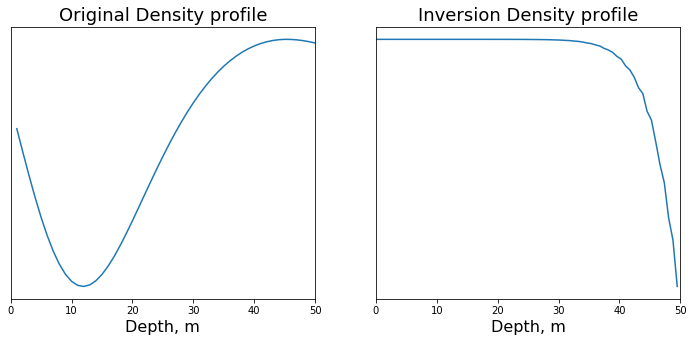

In [20]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1, 2, 1)
ax.plot(-da_fdensity.sel(z=slice(0,-50)).z, da_fdensity.sel(z=slice(0,-50)).mean(['y','x']))
ax.set_title('Original Density profile', fontsize=18)
ax.set_xlabel('Depth, m', fontsize=16)
ax.set_yticks([])
ax.set_xlim([0,50])

ax = fig.add_subplot(1, 2, 2)
ax.plot(-da_focal.z, da_focal.mean(['y','x']))
ax.set_title('Inversion Density profile', fontsize=18)
ax.set_xlabel('Depth, m', fontsize=16)
ax.set_yticks([])
ax.set_xlim([0,50])

plt.show()